# ch04.01 UNet-Image segmentation

* 날짜:
* 이름:

## 학습내용
    - Image segmentation에 대해 이해한다.
    - UNet 모델에 대해 이해한다.
    - 이미지 분절 작업을 수행한다.

## Image Segmentation

![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/seg_type.png?raw=true)


![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/seg_model.png?raw=true)

## 모델: UNet
---

![]( https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/unet2.png?raw=true)

#### **레포지토리 임포트**

https://github.com/karolzak/keras-unet

```
! git clone https://github.com/karolzak/keras-unet
```


In [1]:
! git clone https://github.com/karolzak/keras-unet

Cloning into 'keras-unet'...
remote: Enumerating objects: 1234, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1234 (delta 44), reused 75 (delta 34), pack-reused 1136
Receiving objects: 100% (1234/1234), 31.94 MiB | 34.53 MiB/s, done.
Resolving deltas: 100% (372/372), done.


In [ ]:
import sys, os, glob
sys.path.append('/content/keras-unet')

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils, callbacks
from PIL import Image


In [ ]:
from keras_unet.models import vanilla_unet

model = vanilla_unet(input_shape=(572, 572, 3))
model.summary()

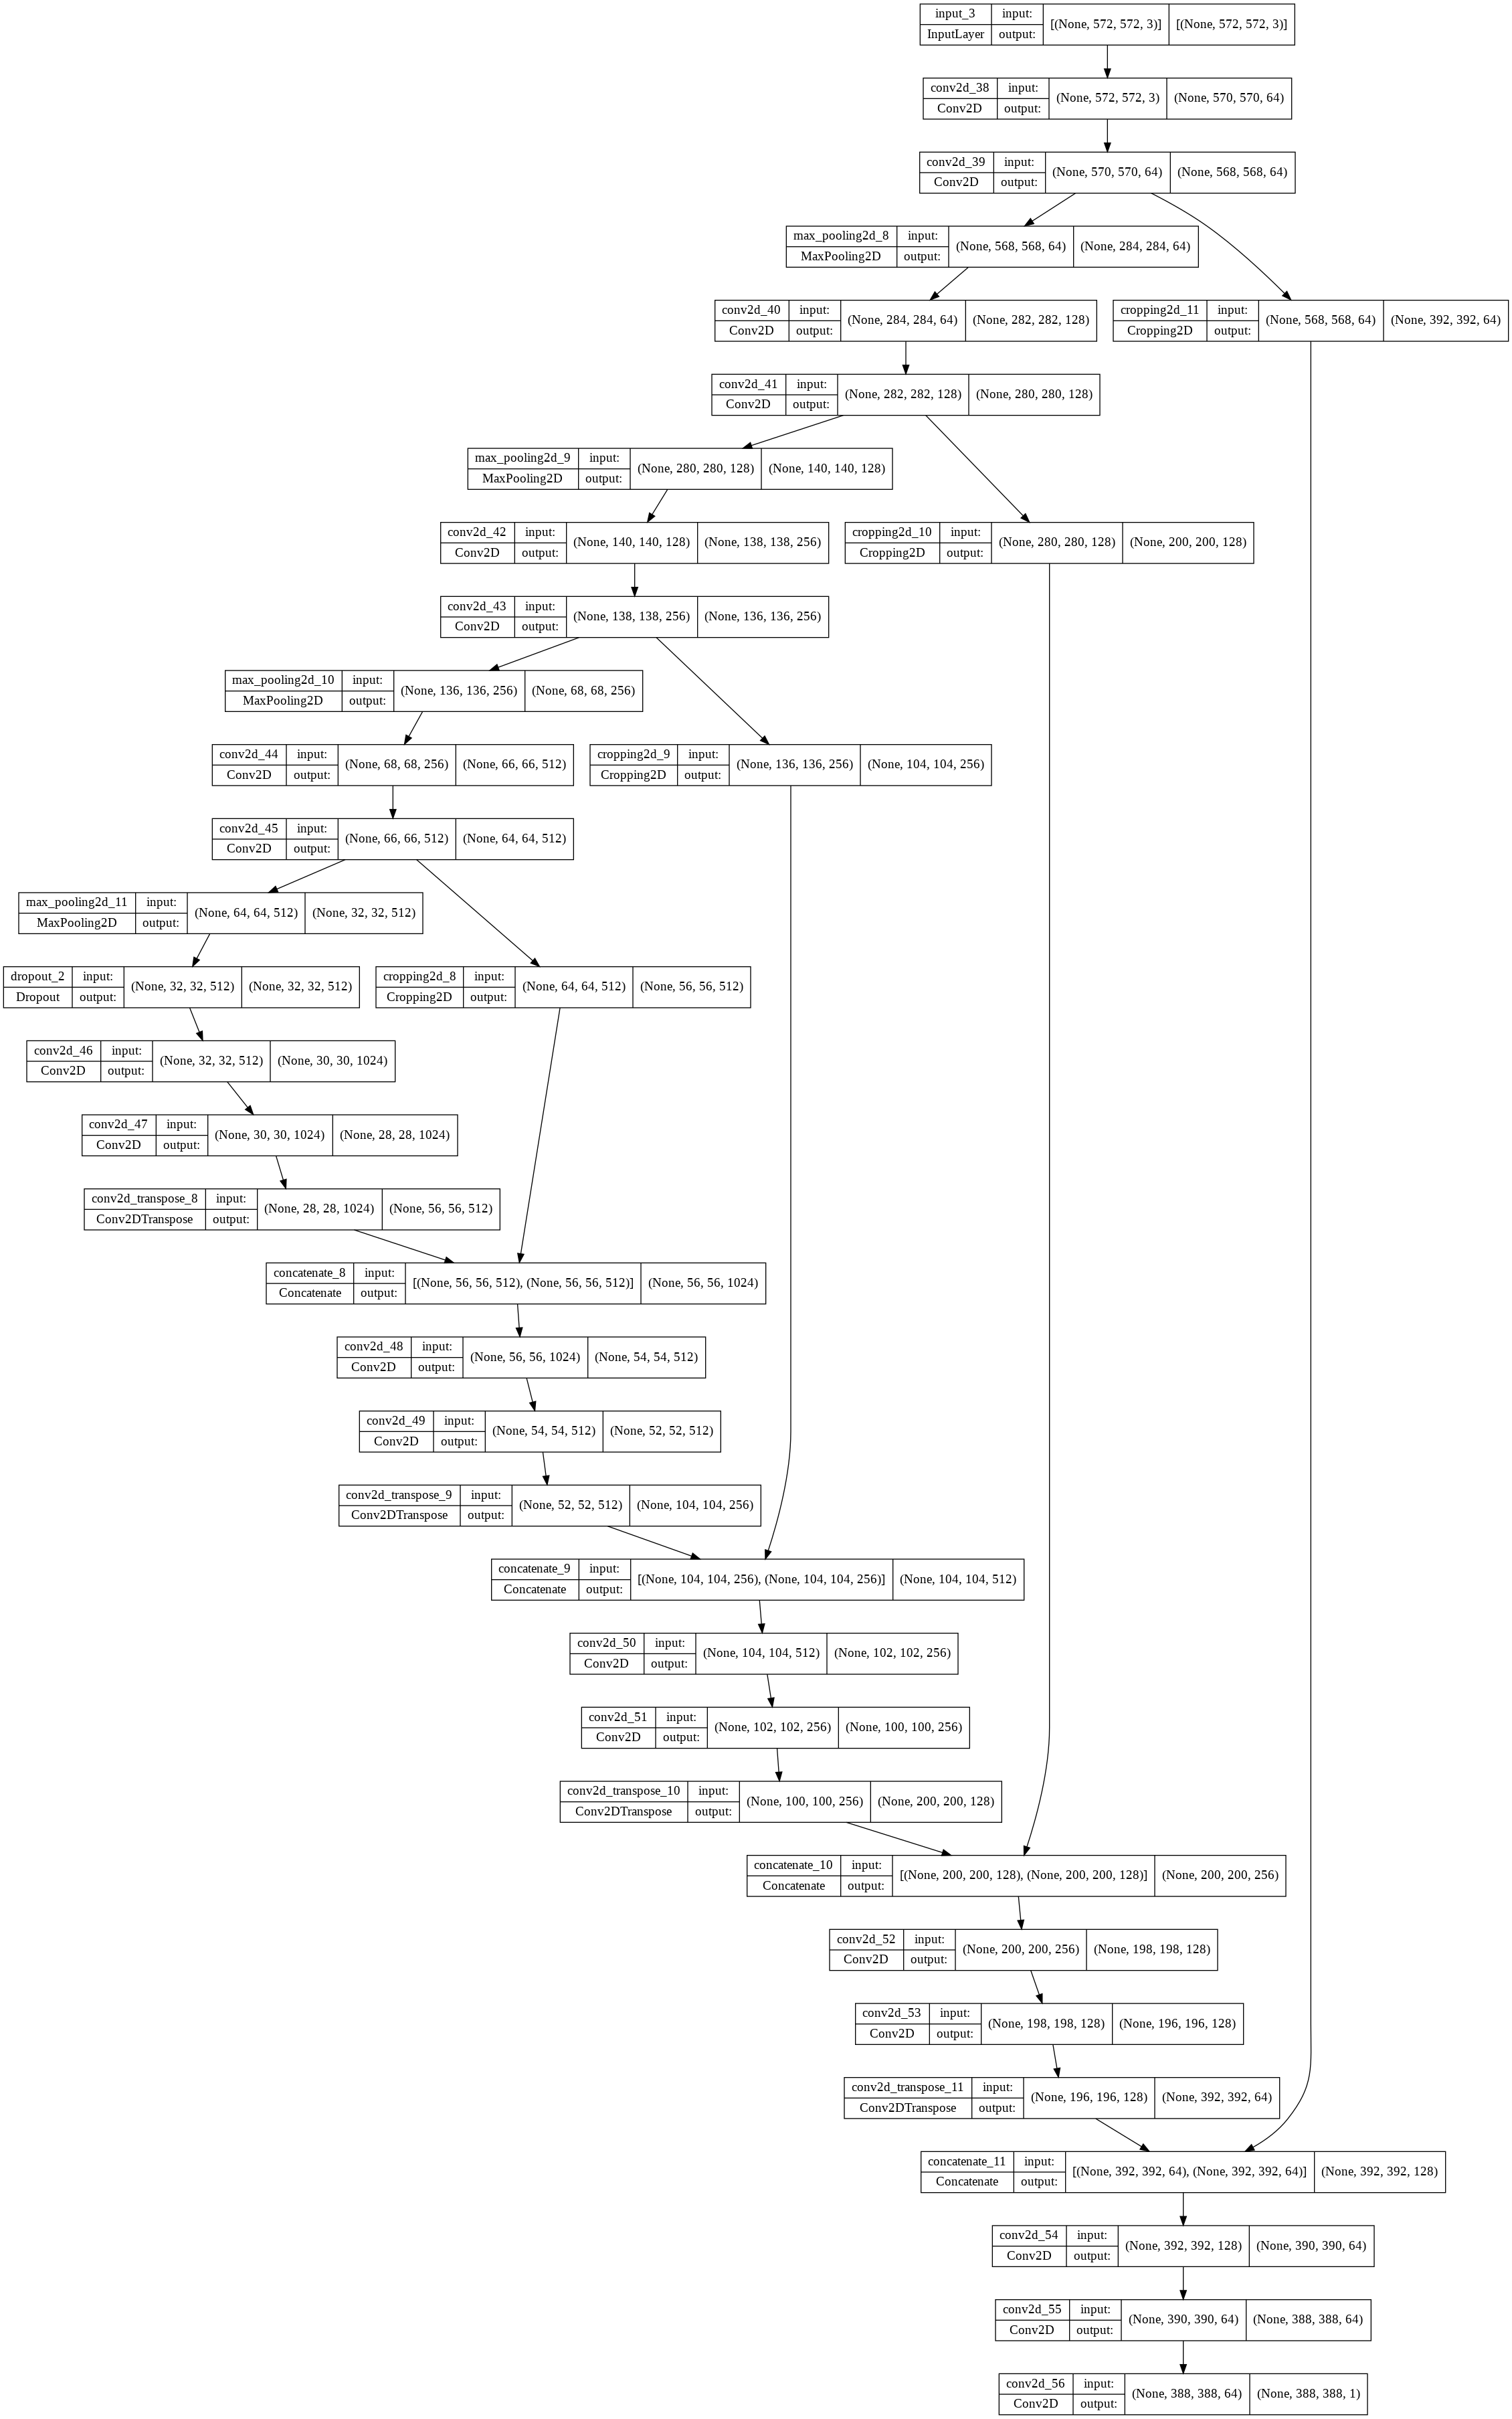

In [ ]:
utils.plot_model(model, show_shapes=True)

#### **모델 생성**

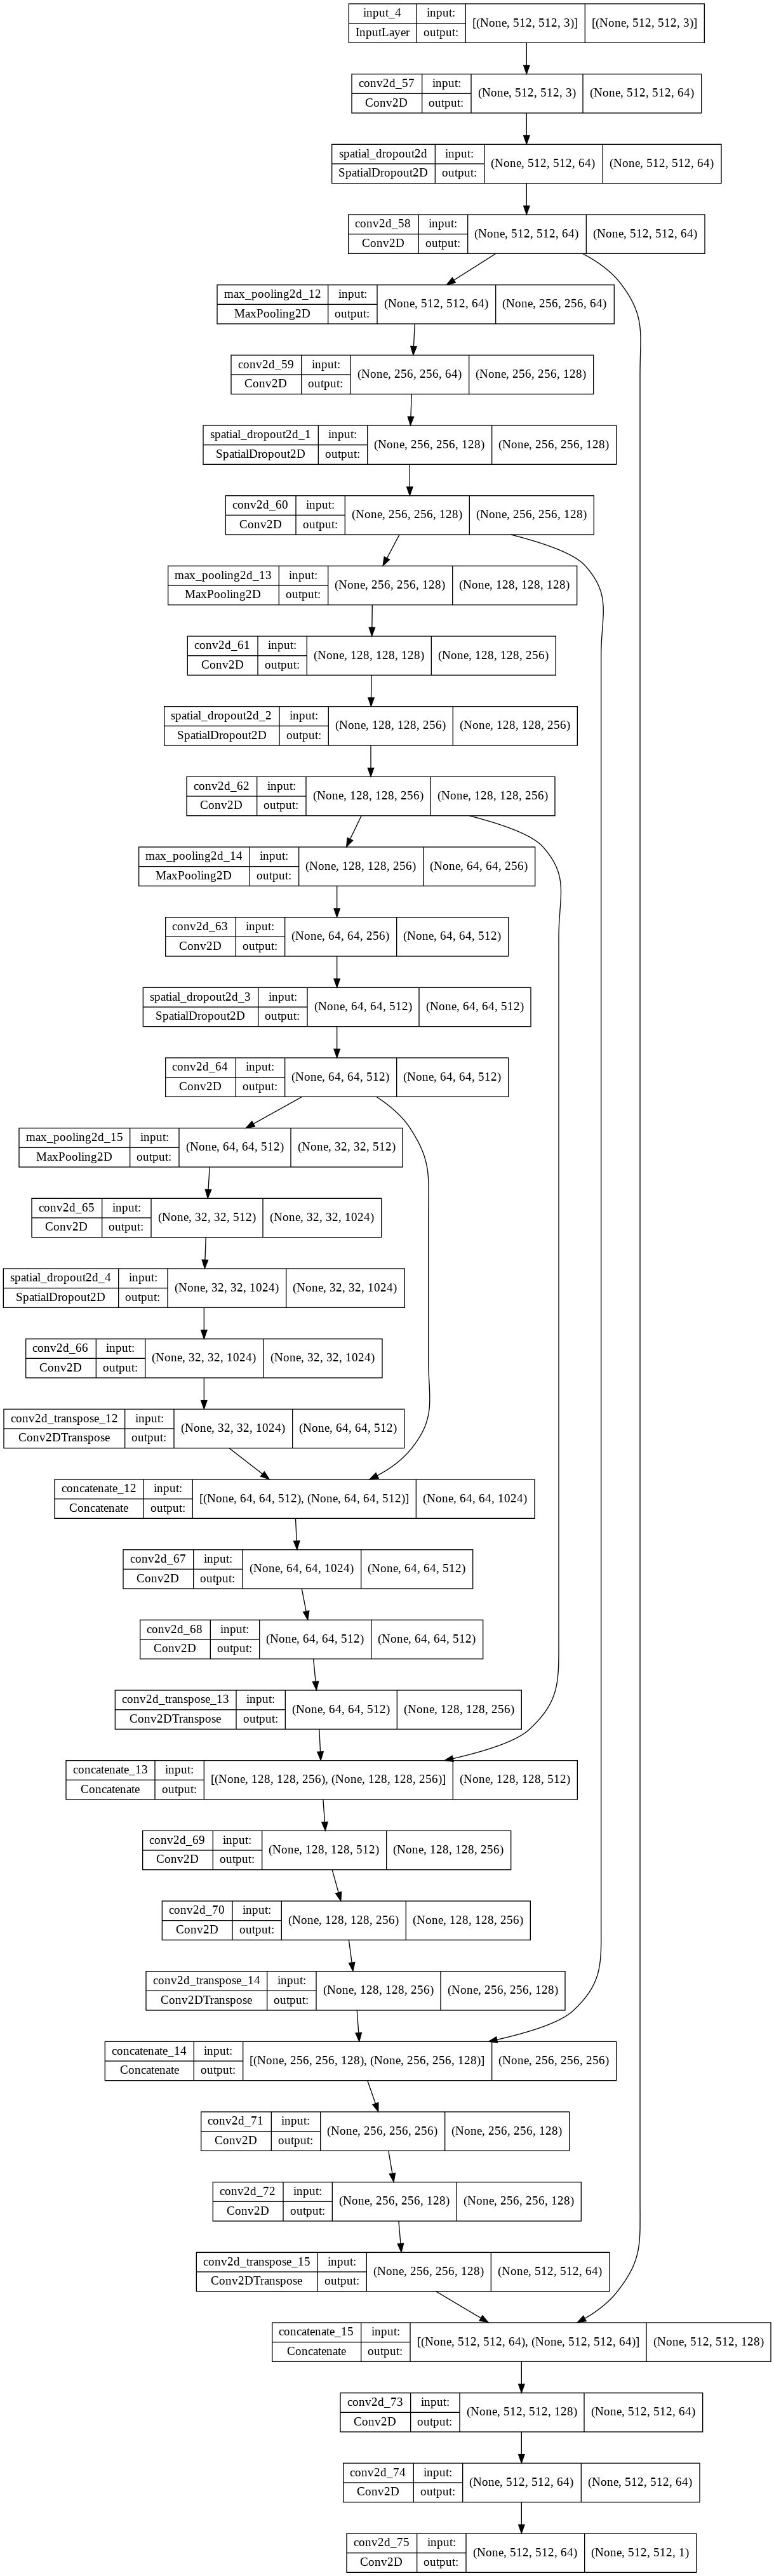

In [ ]:
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape=(512, 512, 3),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid')

utils.plot_model(model, show_shapes=True)

## 데이터셋: Whale-tails
---

### **| 데이터 처리**

#### **데이터 경로 확보**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys

In [ ]:
img_paths = glob.glob('/content/keras-unet/input/whales/*jpg')
mask_paths = glob.glob('/content/keras-unet/input/whales/*png')
print(len(img_paths), img_paths[0])
print(len(mask_paths), mask_paths[0])

500 /content/keras-unet/input/whales/00d641885.jpg
148 /content/keras-unet/input/whales/00e4afee9.png


In [ ]:
img_paths = [mask_path.replace('png','jpg') for mask_path in mask_paths]
print(len(img_paths), img_paths[0])

148 /content/keras-unet/input/whales/00e4afee9.jpg


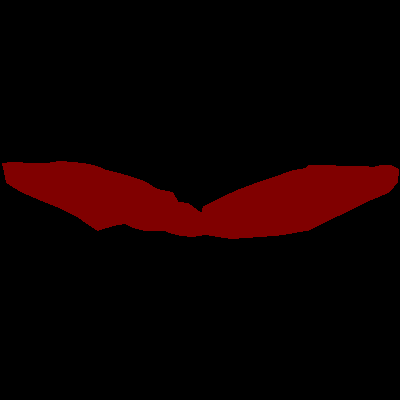

In [ ]:
Image.open(mask_paths[0])

#### **넘파이 변환**

In [ ]:
from PIL import Image

imgs = []
masks = []
for img_path, mask_path in zip(img_paths, mask_paths):
  # print(img_path, mask_path)
  # path2img
  img = Image.open(img_path).resize( (384,384) )
  img = np.array(img)
  # path2mask
  mask = Image.open(mask_path).resize( (384,384) )
  mask = np.array(mask)
  imgs.append(img)
  masks.append(mask)
imgs = np.asarray(imgs)
masks = np.asarray(masks)
masks = np.expand_dims(masks, 3)
imgs.shape, masks.shape


((148, 384, 384, 3), (148, 384, 384, 1))

#### **데이터 확인**

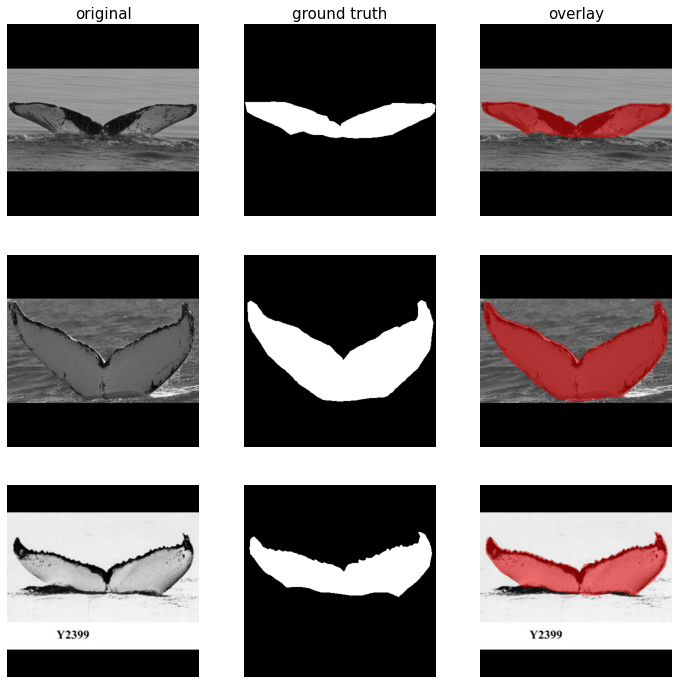

In [ ]:
from keras_unet.utils import plot_imgs

plot_imgs(imgs, masks, nm_img_to_plot=3) # optional - number of images to plot

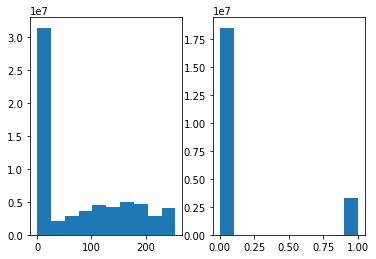

In [ ]:
plt.subplot(121);_=plt.hist(imgs.flatten())
plt.subplot(122);_=plt.hist(masks.flatten())

In [ ]:
mn, mx = np.min(imgs.flatten()), np.max(imgs.flatten())
print(f'인풋 이미지의 값 범위:{mn}, {mx}')
print(f'마스크의 값 범위:{set(mask.flatten())}')

인풋 이미지의 값 범위:0, 255
마스크의 값 범위:{0, 1}


#### **전처리**

In [ ]:
def whale_preprocess(imgs, masks):
  imgs = imgs/255.0
  return imgs, masks

인풋 이미지의 값 범위:0.0, 1.0
마스크의 값 범위:{0, 1}


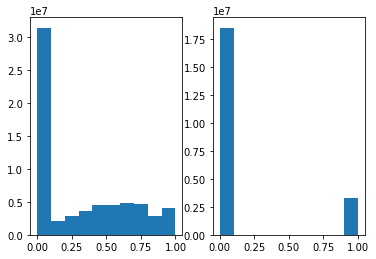

In [ ]:
imgs_ds, masks_ds = whale_preprocess (imgs, masks)
mn, mx = np.min(imgs_ds.flatten()), np.max(imgs_ds.flatten())
print(f'인풋 이미지의 값 범위:{mn}, {mx}')
print(f'마스크의 값 범위:{set(masks_ds.flatten())}')
plt.subplot(121);_=plt.hist(imgs_ds.flatten())
plt.subplot(122);_=plt.hist(masks_ds.flatten())

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(imgs_ds, masks_ds, test_size=.1,
                                                    random_state=0)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((133, 384, 384, 3), (133, 384, 384, 1), (15, 384, 384, 3), (15, 384, 384, 1))

#### **이미지 증강**

In [ ]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(x_train, y_train, batch_size=2,
                           data_gen_args=dict(rotation_range=10.0,                                        
                                              width_shift_range=0.05,
                                              height_shift_range=0.05,
                                              shear_range=40,
                                              # zoom_range=0.3,
                                              horizontal_flip=True,
                                              vertical_flip=False,
                                              fill_mode="constant"))

(2, 384, 384, 3) (2, 384, 384, 1)


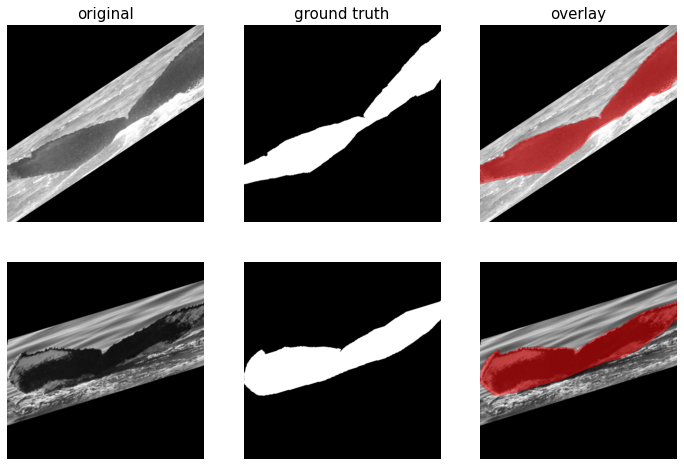

In [ ]:
samples = next(train_gen)
xs, ys = samples
print(xs.shape, ys.shape)
plot_imgs(xs, ys, nm_img_to_plot=2)

### **| 모델 생성 및 학습**

#### **모델 생성**

In [ ]:
model = custom_unet((384,384,3), 
                    filters=34,
                    output_activation='sigmoid')
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_114 (Conv2D)            (None, 384, 384, 34  918         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 384, 384, 34  136        ['conv2d_114[0][0]']             
 ormalization)                  )                                                           

#### **컴파일 및 학습**

In [ ]:
ckp = callbacks.ModelCheckpoint('unet_whale.h5',
                                moniotr = 'val_loss',
                                save_best_only=True)

In [ ]:
from keras_unet.metrics import iou

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[iou])

In [ ]:
history = model.fit(train_gen, epochs=50,
                    steps_per_epoch=200,
                    validation_data=(x_test, y_test),
                    callbacks=[ckp])

Epoch 1/50
200/200 [==============================] - 44s 193ms/step - loss: 0.4230 - iou: 0.2807 - val_loss: 25.3090 - val_iou: 0.1498
Epoch 2/50
200/200 [==============================] - 30s 152ms/step - loss: 0.2330 - iou: 0.4123 - val_loss: 0.9648 - val_iou: 0.3490
Epoch 3/50
200/200 [==============================] - 30s 150ms/step - loss: 0.1844 - iou: 0.4934 - val_loss: 0.2781 - val_iou: 0.5767
Epoch 4/50
200/200 [==============================] - 31s 153ms/step - loss: 0.1556 - iou: 0.5560 - val_loss: 0.2272 - val_iou: 0.5832
Epoch 5/50
200/200 [==============================] - 30s 151ms/step - loss: 0.1435 - iou: 0.5843 - val_loss: 0.1146 - val_iou: 0.6866
Epoch 6/50
200/200 [==============================] - 30s 148ms/step - loss: 0.1253 - iou: 0.6273 - val_loss: 0.1310 - val_iou: 0.6909
Epoch 7/50
200/200 [==============================] - 30s 152ms/step - loss: 0.1179 - iou: 0.6528 - val_loss: 0.2475 - val_iou: 0.6241
Epoch 8/50
200/200 [==============================] - 

#### **Plot training history**

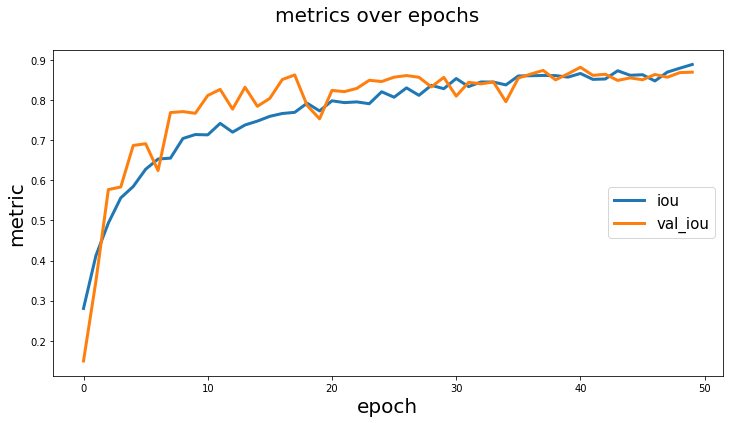

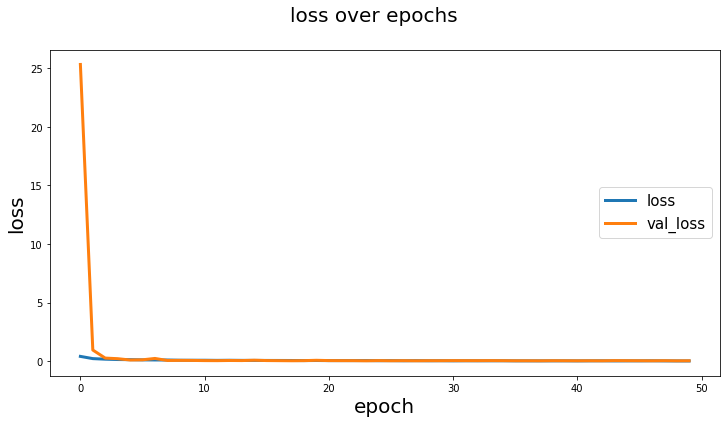

In [ ]:
from keras_unet.utils import plot_segm_history

plot_segm_history(
    history, # required - keras training history object
    metrics=['iou', 'val_iou'], # optional - metrics names to plot
    losses=['loss', 'val_loss']) # optional - loss names to plot

#### **Plot original + ground truth + pred + overlay (pred on top of original)**

In [ ]:
y_pred = model.predict(x_test)
print(y_test.shape, y_pred.shape)

(15, 384, 384, 1) (15, 384, 384, 1)


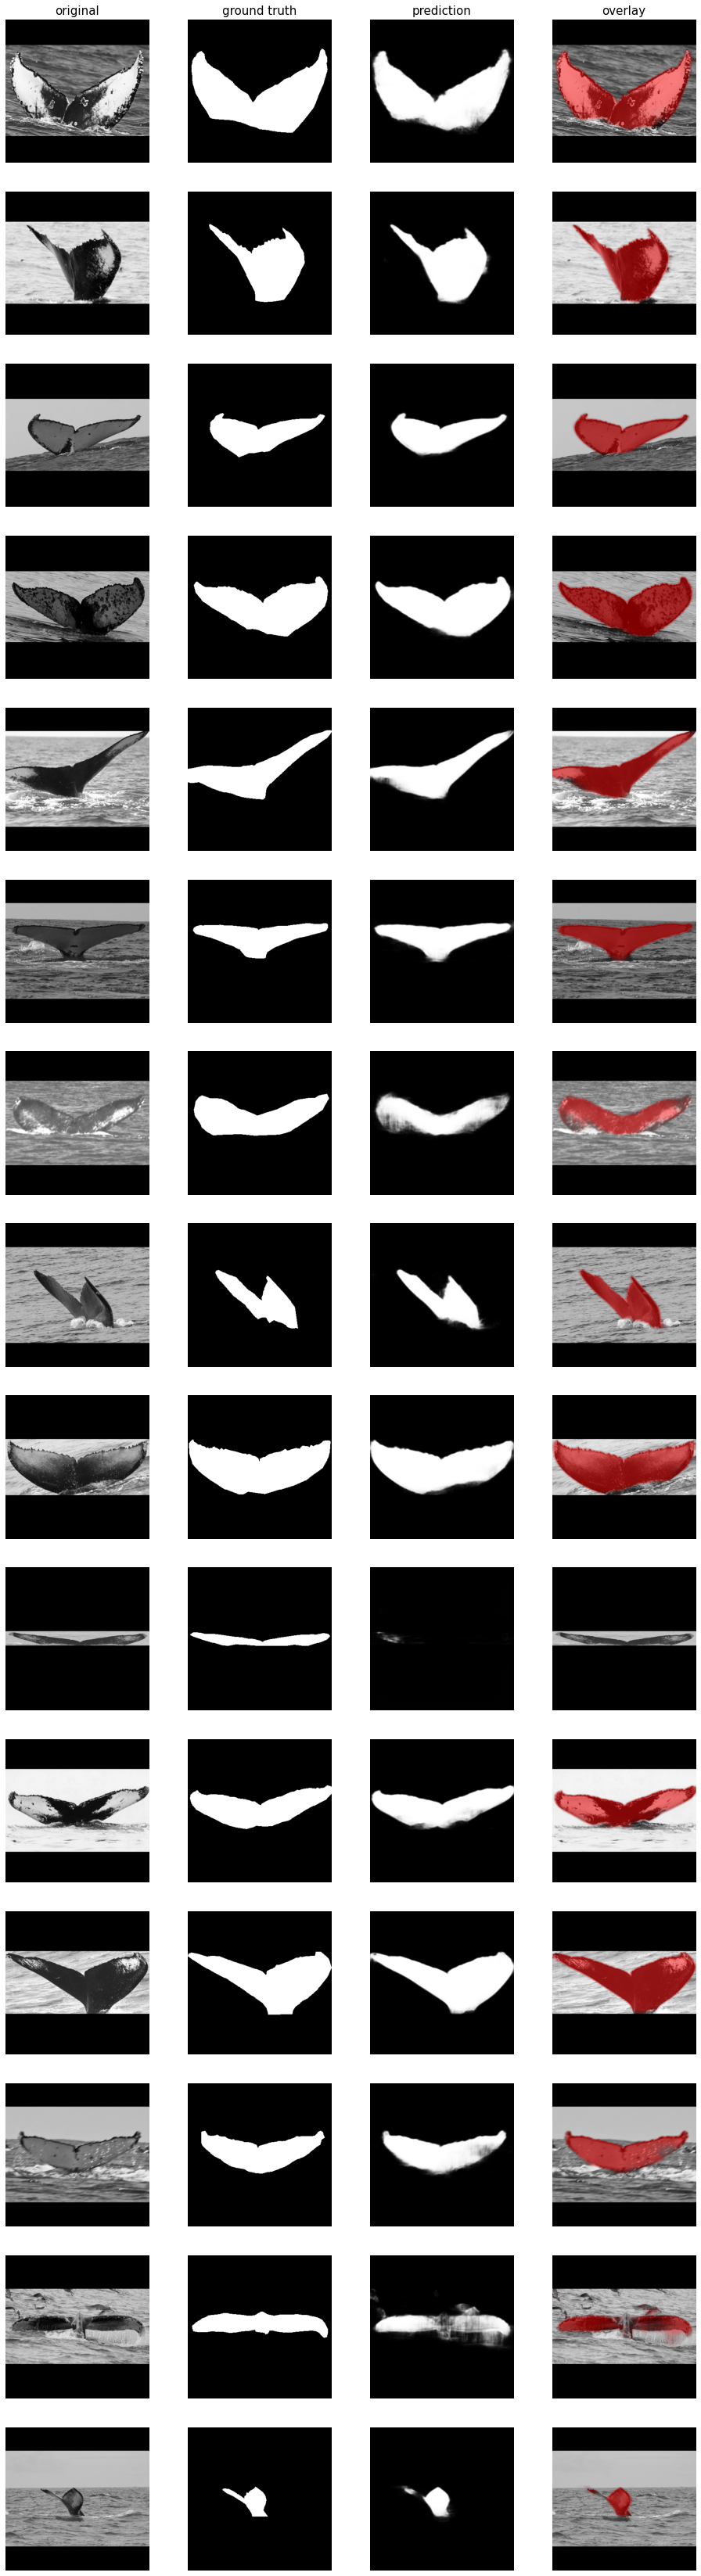

In [ ]:
plot_imgs(org_imgs=x_test, 
          mask_imgs=y_test, 
          pred_imgs=y_pred,
          nm_img_to_plot=15)

## 데이터셋: kz-isbi-challenge
---

https://github.com/karolzak/keras-unet/blob/master/notebooks/kz-isbi-challenge.ipynb

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image

In [3]:
sys.path.append('/content/keras-unet')

In [4]:
masks = glob.glob("/content/keras-unet/input/isbi2015/train/label/*.png")
orgs = glob.glob("/content/keras-unet/input/isbi2015/train/image/*.png")

In [9]:
# 이미지를 넘파이 배열로 변환

imgs_list = []
masks_list = []
for image, mask in zip(orgs, masks):
    imgs_list.append(np.array(Image.open(image).resize((512,512))))
    
    im = Image.open(mask).resize((512,512))
    #width, height = im.size   # Get dimensions

    #left = (width - 388)/2
    #top = (height - 388)/2
    #right = (width + 388)/2
    #bottom = (height + 388)/2

    #im_cropped = im.crop((left, top, right, bottom))
    masks_list.append(np.array(im))

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

In [6]:
print(imgs_np.shape, masks_np.shape)

(30, 512, 512) (30, 512, 512)


In [10]:
imgs_np = np.expand_dims(imgs_np, 3)
masks_np = np.expand_dims(masks_np, 3)
print(imgs_np.shape, masks_np.shape)

(30, 512, 512, 1) (30, 512, 512, 1)


# 데이터 확인

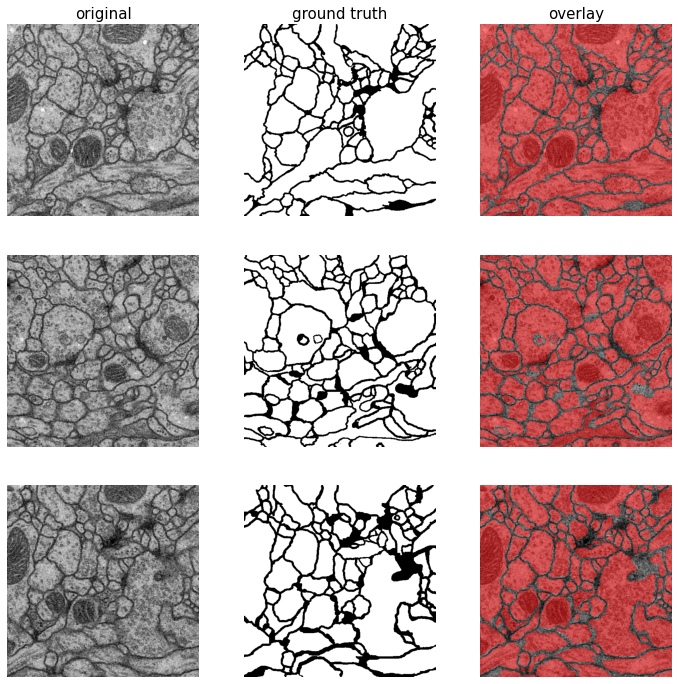

In [12]:
from keras_unet.utils import plot_imgs

plot_imgs(imgs_np, masks_np, nm_img_to_plot=3) # optional - number of images to plot

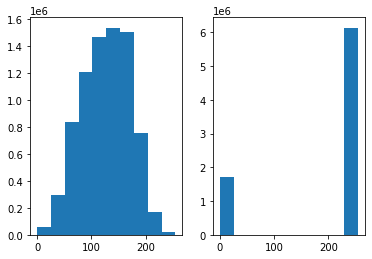

In [13]:
plt.subplot(121);_=plt.hist(imgs_np.flatten())
plt.subplot(122);_=plt.hist(masks_np.flatten())

In [14]:
mn, mx = np.min(imgs_np.flatten()), np.max(imgs_np.flatten())
print(f'인풋 이미지의 값 범위:{mn}, {mx}')
print(f'마스크의 값 범위:{set(masks_np.flatten())}')

인풋 이미지의 값 범위:0, 255
마스크의 값 범위:{0, 255}


In [15]:
x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)/255

인풋 이미지의 값 범위:0.0, 1.0
마스크의 값 범위:{0.0, 1.0}


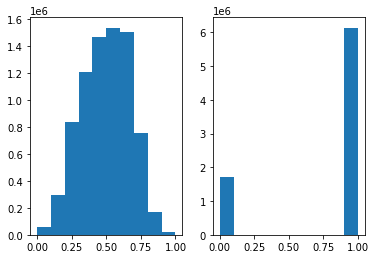

In [16]:
mn, mx = np.min(x.flatten()), np.max(x.flatten())
print(f'인풋 이미지의 값 범위:{mn}, {mx}')
print(f'마스크의 값 범위:{set(y.flatten())}')
plt.subplot(121);_=plt.hist(x.flatten())
plt.subplot(122);_=plt.hist(y.flatten())

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (15, 512, 512, 1)
y_train:  (15, 512, 512, 1)
x_val:  (15, 512, 512, 1)
y_val:  (15, 512, 512, 1)


In [18]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 512, 512, 1) (2, 512, 512, 1)


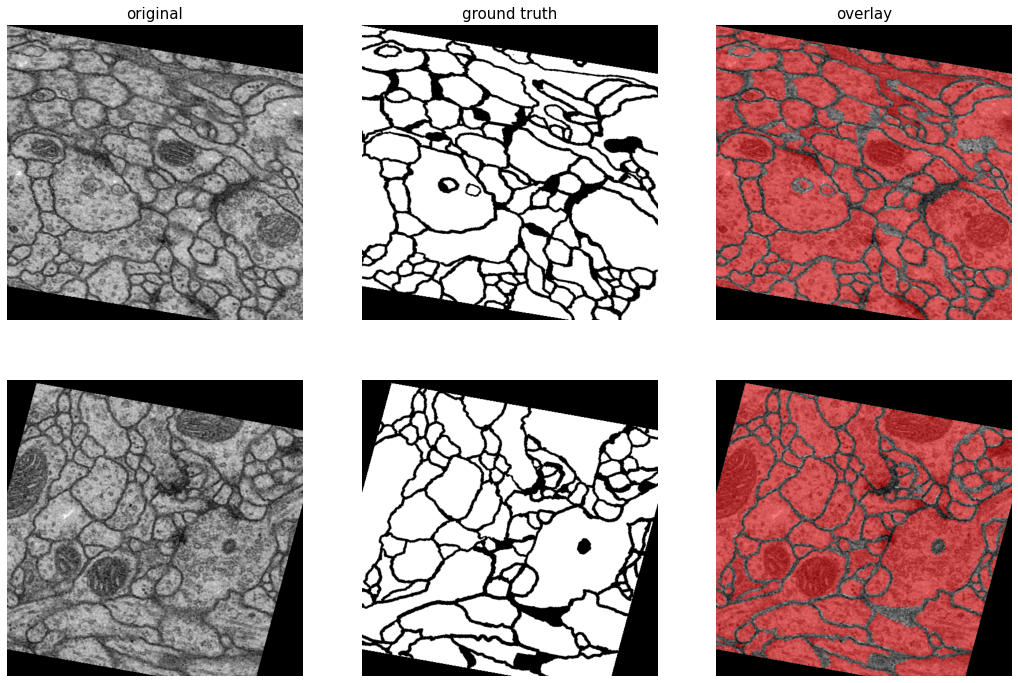

In [19]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [20]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 512, 512, 64  0          ['conv2d[0][0]']                 
 out2D)                         )                                                             

In [22]:
from keras.callbacks import ModelCheckpoint


model_filename = 'segm_model_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [25]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

In [26]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=10,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


100/100 [==============================] - ETA: 0s - loss: 0.4368 - iou: 0.6722 - iou_thresholded: 0.7562
Epoch 1: val_loss improved from inf to 0.37446, saving model to segm_model_v0.h5
100/100 [==============================] - 95s 726ms/step - loss: 0.4368 - iou: 0.6722 - iou_thresholded: 0.7562 - val_loss: 0.3745 - val_iou: 0.7023 - val_iou_thresholded: 0.8002
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.3339 - iou: 0.7231 - iou_thresholded: 0.7941
Epoch 2: val_loss improved from 0.37446 to 0.37398, saving model to segm_model_v0.h5
100/100 [==============================] - 46s 455ms/step - loss: 0.3339 - iou: 0.7231 - iou_thresholded: 0.7941 - val_loss: 0.3740 - val_iou: 0.6968 - val_iou_thresholded: 0.8056
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.3212 - iou: 0.7311 - iou_thresholded: 0.7960
Epoch 3: val_loss improved from 0.37398 to 0.36214, saving model to segm_model_v0.h5
100/100 [==============================] - 46s 45

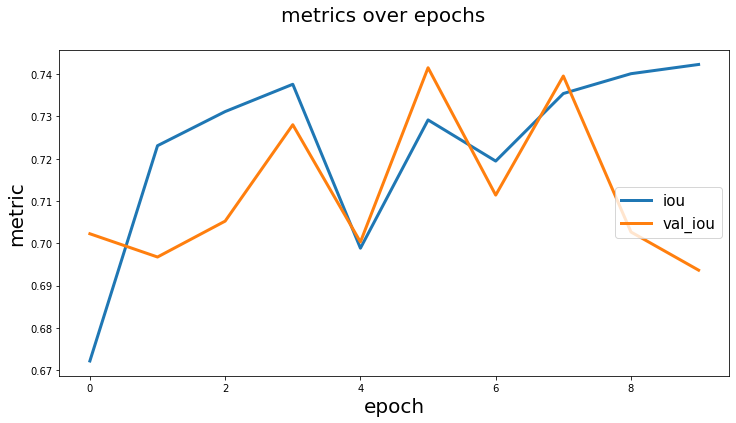

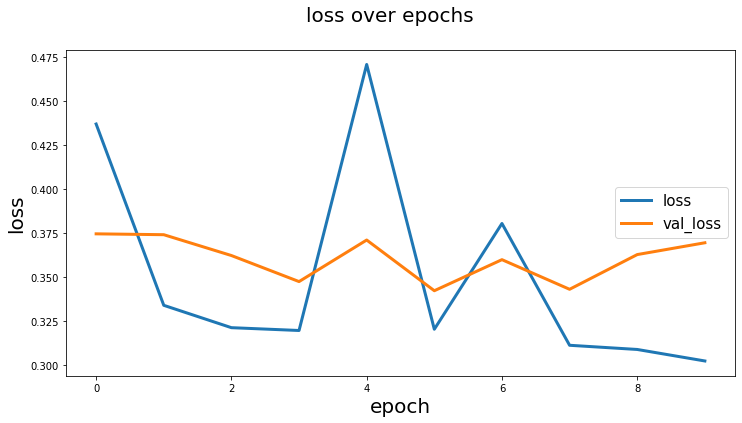

In [27]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [28]:
y_pred = model.predict(x_val)

In [29]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=9)

Output hidden; open in https://colab.research.google.com to view.